# 📈 LSTM-Based Time Series Forecasting with PyTorch on Airline Passenger Data
This notebook demonstrates a complete machine learning workflow for univariate time series forecasting using a Long Short-Term Memory (LSTM) neural network implemented in PyTorch, applied to the classic Airline Passenger dataset from sktime. The project includes data loading, sequence generation, Min-Max scaling, exploratory data analysis (EDA), LSTM model definition and training, performance evaluation with MAE/RMSE metrics, and both one-step and multi-step forecasting visualizations.

In [1]:
# ============================================
# 1. Import Libraries and Configure Plotting
# ============================================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Plotting style
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-v0_8-whitegrid')
%config InlineBackend.figure_format = 'retina'

Dataset shape: (144, 1)


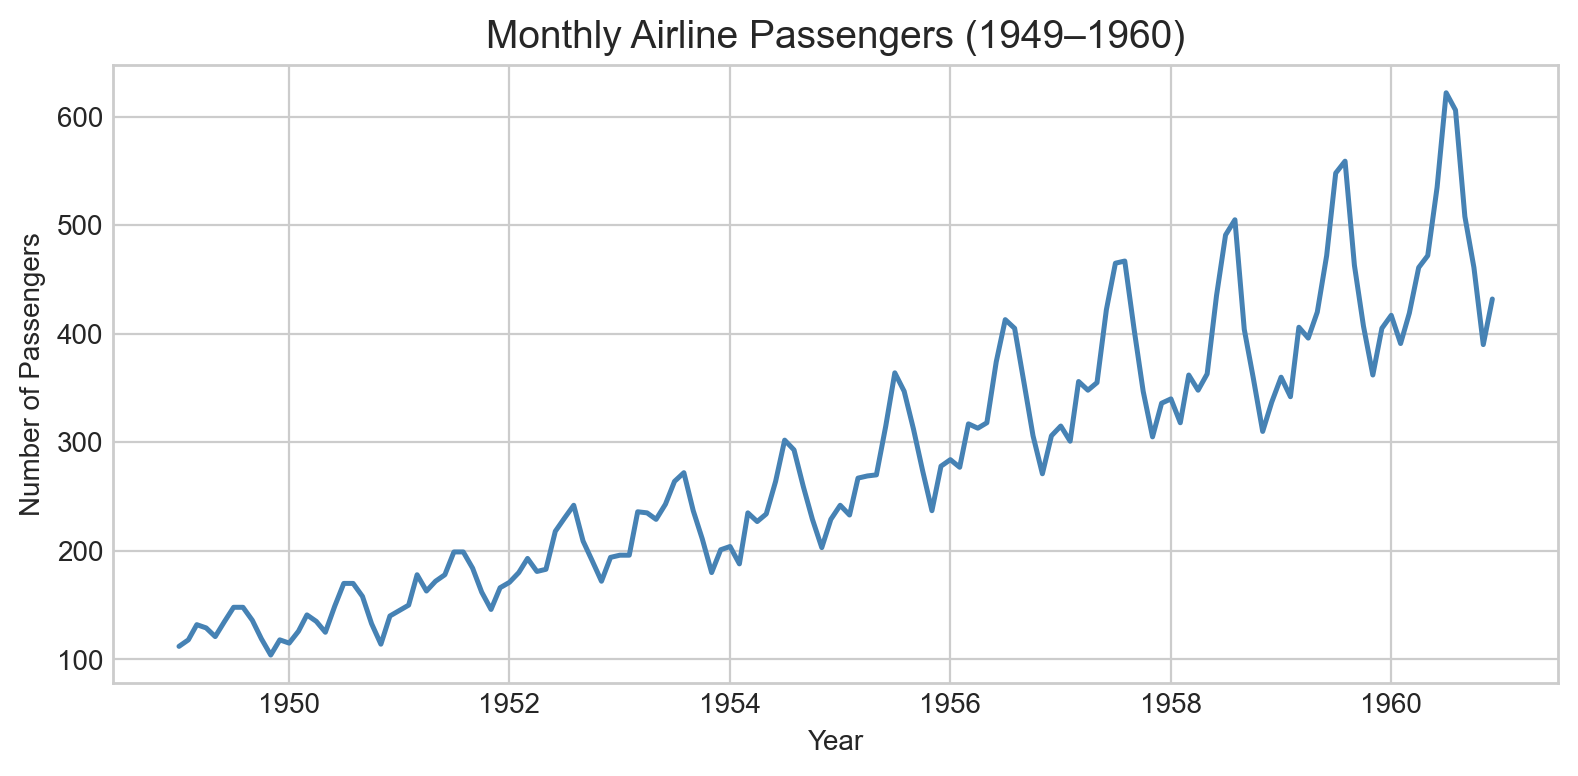

In [2]:
# ============================================
# 2. Load and Inspect the Airline Passenger Data
# ============================================
from sktime.datasets import load_airline

# Load the dataset (returns a pandas Series with monthly frequency)
y = load_airline()

# 🔧 FIX: Convert PeriodIndex to DatetimeIndex for plotting
y.index = y.index.to_timestamp()

# Convert to DataFrame for easier handling
data = y.to_frame(name='Passengers')

# Display basic info
print("Dataset shape:", data.shape)

# Plot the raw time series
plt.figure(figsize=(8, 4))
plt.plot(data.index, data['Passengers'], color='steelblue', linewidth=1.8)
plt.title('Monthly Airline Passengers (1949–1960)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.tight_layout()
plt.show()

In [3]:
# ============================================
# 3. Data Preprocessing: Create Sequences & Scale
# ============================================

def create_sequences(data, seq_length):
    """
    Transform time series into input-output sequences for supervised learning.
    Input: [x_t, x_{t+1}, ..., x_{t+seq_len-1}] → Output: x_{t+seq_len}
    """
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Parameters
SEQ_LENGTH = 12  # Use 12 months to predict the next month
TRAIN_RATIO = 0.8

# Normalize the data to [0, 1]
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data).flatten()

# Create sequences
X, y = create_sequences(data_scaled, SEQ_LENGTH)

# Split into train and test
split_idx = int(len(X) * TRAIN_RATIO)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train).unsqueeze(-1)  # Add feature dimension
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test).unsqueeze(-1)
y_test = torch.FloatTensor(y_test)

print(f"Training sequences: {X_train.shape}")
print(f"Test sequences: {X_test.shape}")
print("Data scaled to [0, 1] and split into input-output sequences.")

Training sequences: torch.Size([105, 12, 1])
Test sequences: torch.Size([27, 12, 1])
Data scaled to [0, 1] and split into input-output sequences.


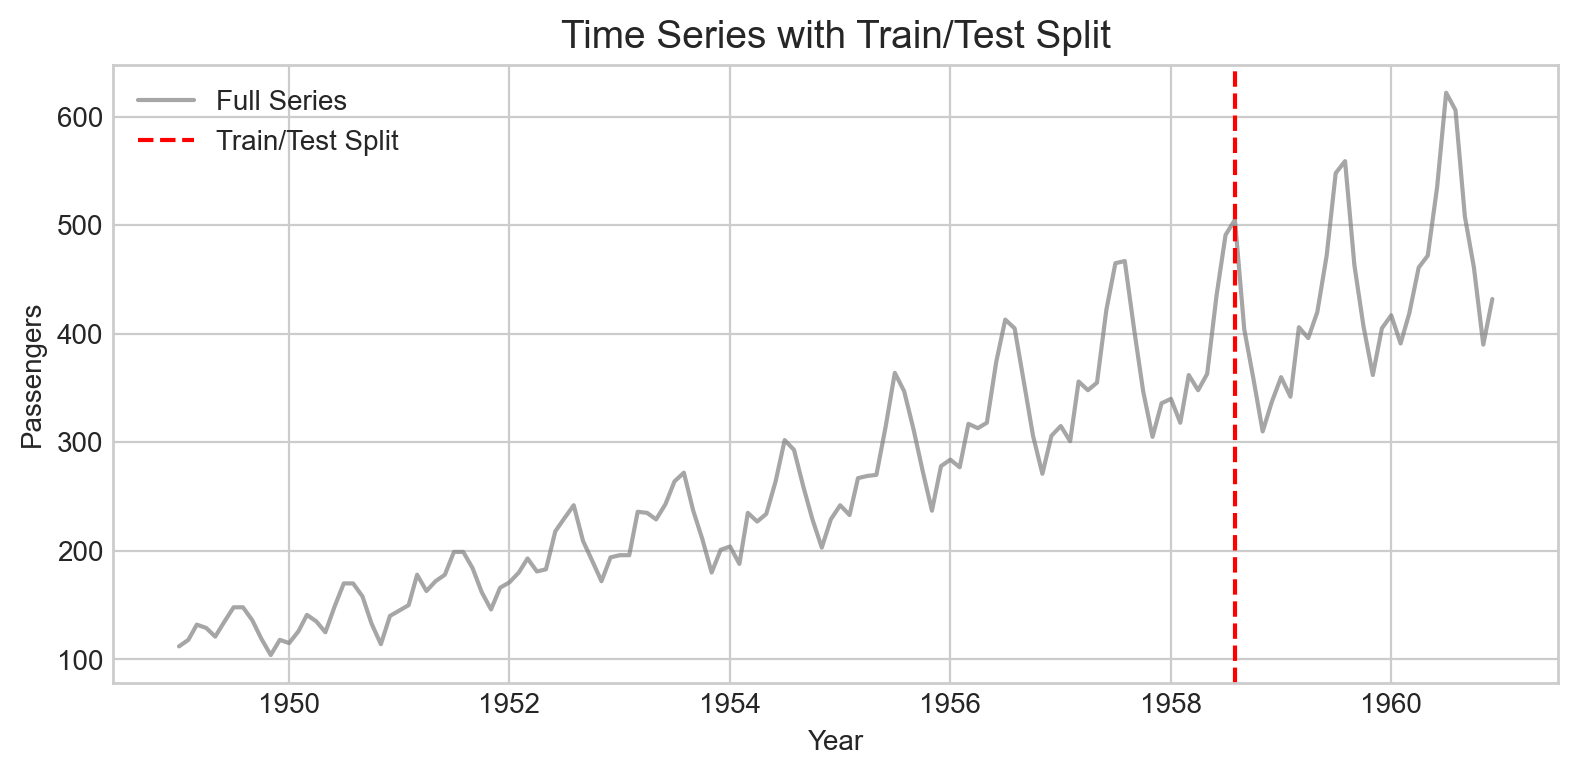

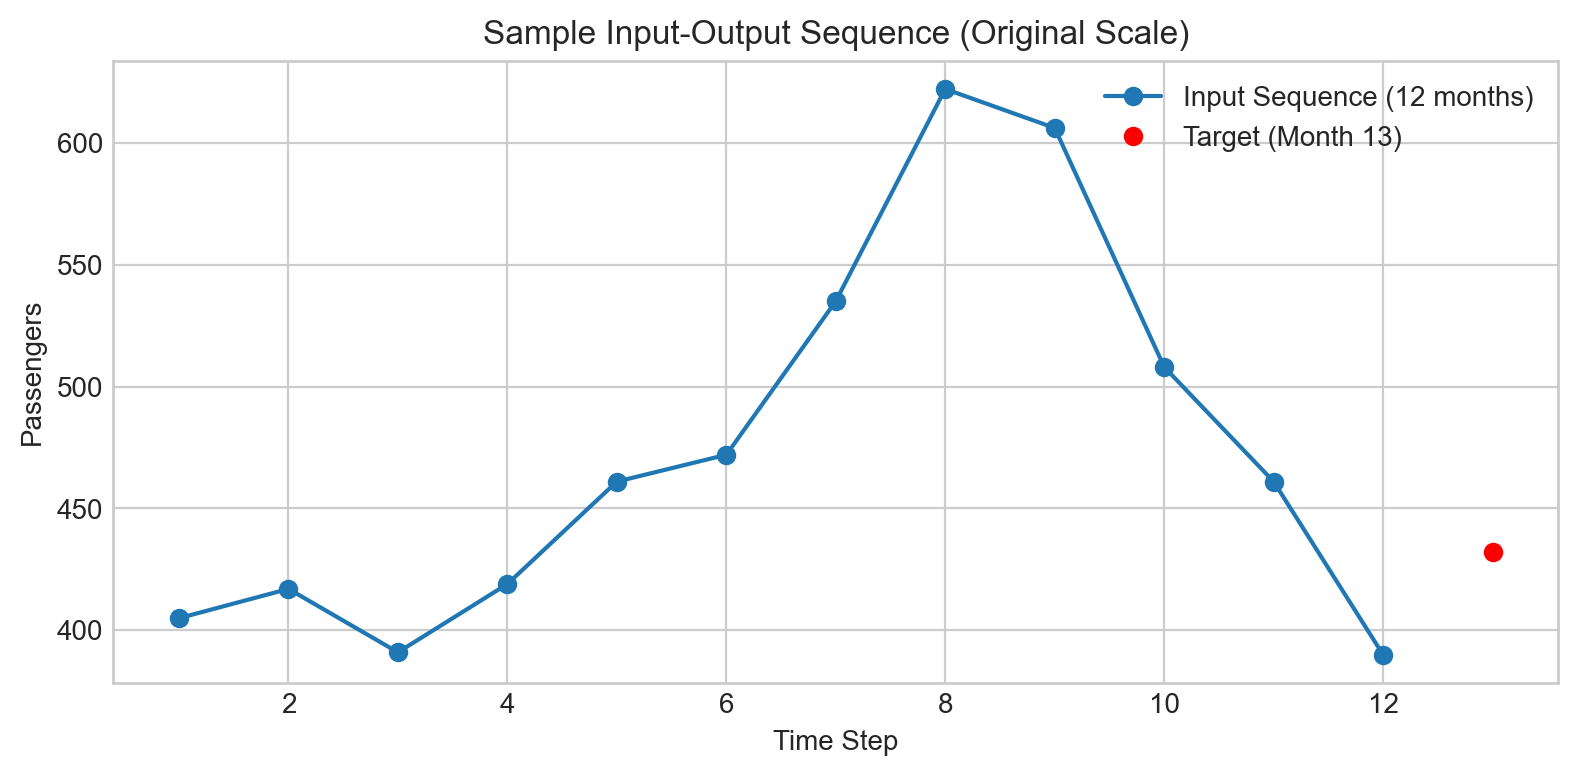

In [4]:
# ============================================
# 4. Exploratory Data Analysis (EDA)
# ============================================

# Reconstruct original-scale series for plotting
original_series = data['Passengers'].values
dates = data.index

# Plot decomposition: train vs test split in original scale
split_time = int(len(original_series) * TRAIN_RATIO)
plt.figure(figsize=(8, 4))
plt.plot(dates, original_series, label='Full Series', color='gray', alpha=0.7)
plt.axvline(x=dates[split_time], color='red', linestyle='--', label='Train/Test Split')
plt.title('Time Series with Train/Test Split', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Passengers')
plt.legend()
plt.tight_layout()
plt.show()

# Visualize a sample input sequence and its target
sample_idx = -1
sample_input = X_test[sample_idx].squeeze().numpy()
sample_target = y_test[sample_idx].item()

# Inverse transform for visualization
sample_input_orig = scaler.inverse_transform(sample_input.reshape(-1, 1)).flatten()
sample_target_orig = scaler.inverse_transform([[sample_target]])[0, 0]

plt.figure(figsize=(8, 4))
plt.plot(range(1, SEQ_LENGTH + 1), sample_input_orig, 'o-', label='Input Sequence (12 months)')
plt.plot([SEQ_LENGTH + 1], [sample_target_orig], 'ro', label='Target (Month 13)')
plt.title('Sample Input-Output Sequence (Original Scale)')
plt.xlabel('Time Step')
plt.ylabel('Passengers')
plt.legend()
plt.tight_layout()
plt.show()

Epoch 50/200, Loss: 0.007296
Epoch 100/200, Loss: 0.004776
Epoch 150/200, Loss: 0.002241
Epoch 200/200, Loss: 0.001516


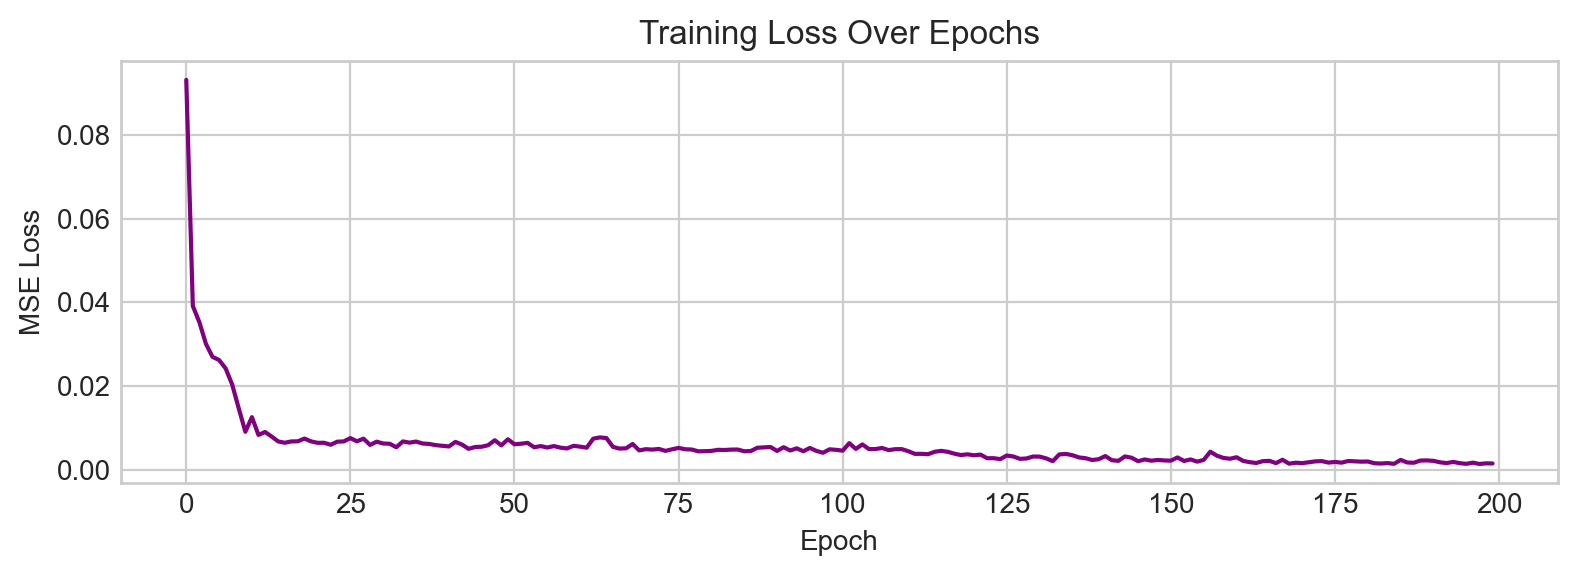

In [5]:
# ============================================
# 5. Define and Train the LSTM Model
# ============================================

class LSTMForecaster(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        # Use the last time step's output
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMForecaster(hidden_size=64, num_layers=2).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Prepare data loaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True)

# Training loop
EPOCHS = 200
train_losses = []

model.train()
for epoch in range(EPOCHS):
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch).squeeze()
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.6f}")

# Plot training loss
plt.figure(figsize=(8, 3))
plt.plot(train_losses, color='purple')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.tight_layout()
plt.show()

Test Set Performance:
MAE: 55.39 passengers
RMSE: 67.14 passengers


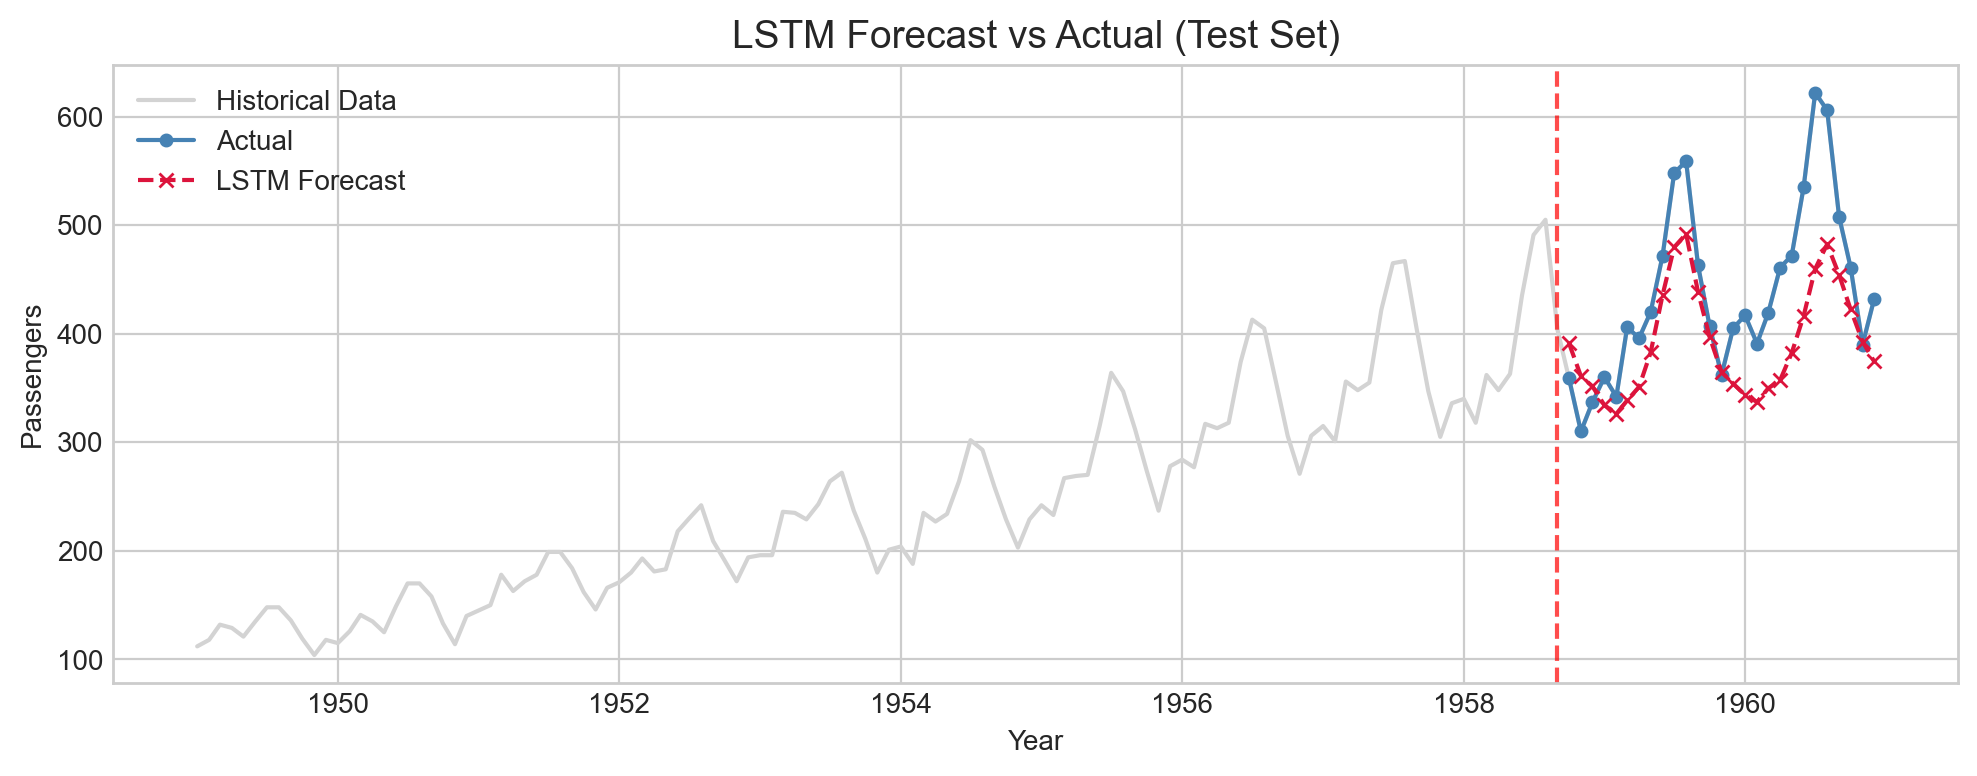

In [8]:
# ============================================
# 6. Model Evaluation and Forecasting
# ============================================

# Evaluate on test set
model.eval()
with torch.no_grad():
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    y_pred_test = model(X_test).squeeze().cpu().numpy()
    y_test_np = y_test.cpu().numpy()

# Inverse transform to original scale
y_pred_orig = scaler.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()
y_true_orig = scaler.inverse_transform(y_test_np.reshape(-1, 1)).flatten()

# Compute metrics
mae = mean_absolute_error(y_true_orig, y_pred_orig)
rmse = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))

print(f"Test Set Performance:")
print(f"MAE: {mae:.2f} passengers")
print(f"RMSE: {rmse:.2f} passengers")

# Plot predictions vs actual
test_dates = dates[split_idx + SEQ_LENGTH : split_idx + SEQ_LENGTH + len(y_true_orig)]

plt.figure(figsize=(10, 4))
plt.plot(dates, original_series, label='Historical Data', color='lightgray')
plt.plot(test_dates, y_true_orig, 'o-', color='steelblue', label='Actual', markersize=4)
plt.plot(test_dates, y_pred_orig, 'x--', color='crimson', label='LSTM Forecast', markersize=5)
plt.axvline(x=dates[split_idx + SEQ_LENGTH - 1], color='red', linestyle='--', alpha=0.7)
plt.title('LSTM Forecast vs Actual (Test Set)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Passengers')
plt.legend()
plt.tight_layout()
plt.show()

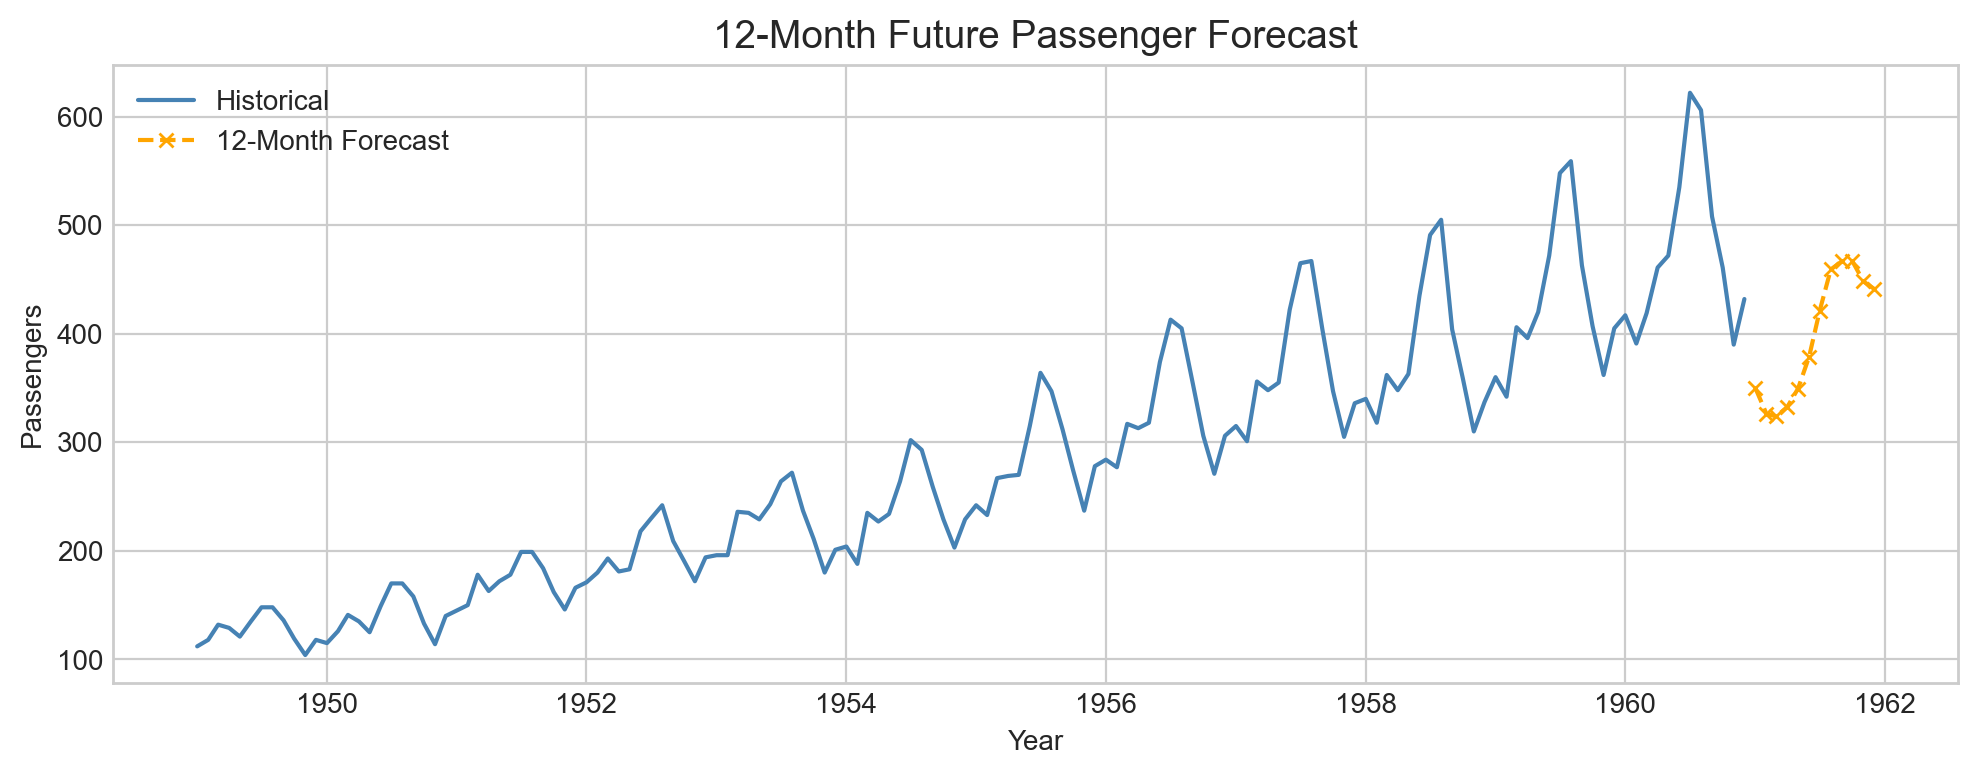

Future 12-month forecast (passengers):
1961-01: 349
1961-02: 326
1961-03: 323
1961-04: 332
1961-05: 349
1961-06: 378
1961-07: 421
1961-08: 459
1961-09: 466
1961-10: 466
1961-11: 448
1961-12: 441


In [16]:
# ============================================
# 7. Optional: Multi-Step Forecasting (Rolling)
# ============================================

def forecast_future(model, last_sequence, steps, scaler, device):
    """Generate multi-step ahead forecasts using recursive prediction."""
    model.eval()
    forecasts = []
    input_seq = last_sequence.copy()

    with torch.no_grad():
        for _ in range(steps):
            # Prepare input
            inp = torch.FloatTensor(input_seq).unsqueeze(0).unsqueeze(-1).to(device)
            pred = model(inp).item()
            forecasts.append(pred)
            # Update sequence: drop first, append prediction
            input_seq = np.append(input_seq[1:], pred)

    # Inverse transform
    forecasts = np.array(forecasts).reshape(-1, 1)
    return scaler.inverse_transform(forecasts).flatten()

# Forecast next 12 months beyond the dataset
last_sequence = data_scaled[-SEQ_LENGTH:]
future_forecast = forecast_future(model, last_sequence, steps=12, scaler=scaler, device=device)

# Create future dates
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='MS')

# Plot historical + forecast
plt.figure(figsize=(10, 4))
plt.plot(data.index, data['Passengers'], label='Historical', color='steelblue')
plt.plot(future_dates, future_forecast, 'x--', color='orange', label='12-Month Forecast', markersize=5)
plt.title('12-Month Future Passenger Forecast', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Passengers')
plt.legend()
plt.tight_layout()
plt.show()

print("Future 12-month forecast (passengers):")
for date, val in zip(future_dates.strftime('%Y-%m'), future_forecast):
    print(f"{date}: {int(val):,}")